<a href="https://colab.research.google.com/github/pkundu25/AI-Research/blob/master/Mining_Classification_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Case Study: Mining Classification

## Business Problem
Mining companies face problems regarding the impurities present in Ore. More the impurities poorer the ore. 
In this problem we have to find **Grade** of Iron ore at the end process based on Silica present. <br/> 
Grade 1- Supreme Quality<br/>
Grade 2- Good Quality<br/>
Grade 3- Average Quality<br/>
Grade 4- Poor Quality

In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 32.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/2f/8e/c1/c1cddd9cf8fbae812904fa5c84ef571e782891288d309d04c8
Successfully built lime


## Import the required Libraries

In [ ]:
import pandas as pd
import pandas_profiling
import dask.dataframe as dd
pd.options.display.max_columns=False
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import lime
import eli5
import shap
%matplotlib inline

**Import the data set**

In [ ]:
from google.colab import files
files.upload()  #Using iron_mining dataset

Saving Iron_mining.xls to Iron_mining.xls


{'Iron_mining.xls': b',date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,grade\r\n677134,2017-08-27 00:00:00,63.64,3.77,2409.63,473.908,379.6564666667,9.22212,1.6901400000000002,300.645,295.45799999999997,301.54200000000003,299.07099999999997,300.904,293.225,300.605,411.80699999999996,504.19199999999995,399.356,429.865,427.22,399.01199999999994,380.20599999999996,65.99,1.04,2\r\n529548,2017-07-23 20:00:00,57.44,14.09,3495.86,514.526,396.18199999999996,9.79135,1.7230400000000001,250.028,250.683,248.112,295.5314085145,294.71

**Read the data with dask**

In [ ]:
dask_train = dd.read_csv('Iron_mining.xls',decimal=",",parse_dates=["date"],infer_datetime_format=True).drop_duplicates()     # Reading data using dask

**Read the data using pandas** 

In [ ]:
df=pd.read_csv('Iron_mining.xls',decimal=",",parse_dates=["date"],infer_datetime_format=True).drop_duplicates()

In [ ]:
df.shape

(5000, 26)

In [ ]:
df.head()

Unnamed: 0                date  ... % Silica Concentrate grade
0      677134 2017-08-27 00:00:00  ...                 1.04     2
1      529548 2017-07-23 20:00:00  ...                  1.6     2
2       88250 2017-04-12 17:00:00  ...                 2.64     3
3      714298 2017-09-04 15:00:00  ...                  2.3     3
4      710528 2017-09-03 18:00:00  ...                 3.02     4

[5 rows x 26 columns]

**Exploratory Data Analysis**

In [ ]:
del df['Unnamed: 0']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
date                            5000 non-null datetime64[ns]
% Iron Feed                     5000 non-null object
% Silica Feed                   5000 non-null object
Starch Flow                     5000 non-null object
Amina Flow                      5000 non-null object
Ore Pulp Flow                   5000 non-null object
Ore Pulp pH                     5000 non-null object
Ore Pulp Density                5000 non-null object
Flotation Column 01 Air Flow    5000 non-null object
Flotation Column 02 Air Flow    5000 non-null object
Flotation Column 03 Air Flow    5000 non-null object
Flotation Column 04 Air Flow    5000 non-null object
Flotation Column 05 Air Flow    5000 non-null object
Flotation Column 06 Air Flow    5000 non-null object
Flotation Column 07 Air Flow    5000 non-null object
Flotation Column 01 Level       5000 non-null object
Flotation Column 02 Level       5000 

**Feature Extraction**<br/>
Extract Hour, Month and Day columns from Date column

In [ ]:
df['Hour']=df['date'].dt.hour
df['Month']=df['date'].dt.month

In [ ]:
df['day']=df['date'].dt.dayofweek

In [ ]:
df['day'].value_counts()                                                        # Day counts across the data set

4    735
0    732
2    718
6    716
5    710
3    708
1    681
Name: day, dtype: int64

In [ ]:
del df['date']                                                                  # We can delete date column as it's not required any longer

**Let's check shape, missing values and data types of the variables**

In [ ]:
print('Shape of the data \n',df.shape)
print('###############--------------')
print('Find Missing values if present\n',df.isnull().sum())
print('###############--------------')
print('Datatype\n',df.dtypes)

Shape of the data 
 (5000, 27)
###############--------------
Find Missing values if present
 % Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
grade                           0
Hour                            0
Month                           0
day                    

**Converting columns having object data type into numeric ones**

In [ ]:
new_df=df.iloc[:,:-5].astype(float)

In [ ]:
new_df1=pd.concat([new_df,df.iloc[:,-4:]],axis=1)

In [ ]:
round(new_df1.head(),2)

% Iron Feed  % Silica Feed  Starch Flow  Amina Flow  ...  grade  Hour  Month  day
0        63.64           3.77      2409.63      473.91  ...      2     0      8    6
1        57.44          14.09      3495.86      514.53  ...      2    20      7    6
2        56.77          11.98      2074.22      548.71  ...      3    17      4    2
3        54.14          14.69      1122.45      477.28  ...      3    15      9    0
4        55.99          15.13      3266.57      525.78  ...      4    18      9    6

[5 rows x 26 columns]

**Let's take a look at the Descriptive Statistics of the data set**

In [ ]:
new_df1.describe().T

count         mean  ...          75%          max
% Iron Feed                   5000.0    56.287182  ...    59.660000    65.780000
% Silica Feed                 5000.0    14.660398  ...    19.580000    33.400000
Starch Flow                   5000.0  2885.549793  ...  3748.682500  6294.080000
Amina Flow                    5000.0   487.692110  ...   554.013750   736.939876
Ore Pulp Flow                 5000.0   397.470851  ...   402.819500   418.638000
Ore Pulp pH                   5000.0     9.771589  ...    10.042600    10.807700
Ore Pulp Density              5000.0     1.679455  ...     1.726485     1.848503
Flotation Column 01 Air Flow  5000.0   280.657171  ...   300.146000   368.932750
Flotation Column 02 Air Flow  5000.0   277.157805  ...   300.686000   366.708000
Flotation Column 03 Air Flow  5000.0   281.650409  ...   300.435500   310.301000
Flotation Column 04 Air Flow  5000.0   299.460251  ...   300.631250   305.639740
Flotation Column 05 Air Flow  5000.0   299.902266  ...   301.719500   309.871000
Flotation Column 06 Air Flow  5000.0   292.178445  ...   303.092000   370.361000
Flotation Column 07 Air Flow  5000.0   291.167919  ...   302.110000   369.096000
Flotation Column 01 Level     5000.0   518.212721  ...   592.762000   862.128000
Flotation Column 02 Level     5000.0   520.239799  ...   593.397000   828.306000
Flotation Column 03 Level     5000.0   529.006540  ...   600.599500   886.600125
Flotation Column 04 Level     5000.0   420.361262  ...   484.757500   679.014909
Flotation Column 05 Level     5000.0   425.443931  ...   483.949000   675.626000
Flotation Column 06 Level     5000.0   431.004263  ...   493.689000   698.571481
Flotation Column 07 Level     5000.0   421.413850  ...   475.842000   657.307405
% Iron Concentrate            5000.0    65.035208  ...    65.852500    67.660000
grade                         5000.0     2.756200  ...     4.000000     4.000000
Hour                          5000.0    11.618000  ...    18.000000    23.000000
Month                         5000.0     6.011400  ...     7.000000     9.000000
day                           5000.0     3.005400  ...     5.000000     6.000000

[26 rows x 8 columns]

**Pandas profiling**

In [ ]:
report=pandas_profiling.ProfileReport(new_df1)
report

**Correlation plot**

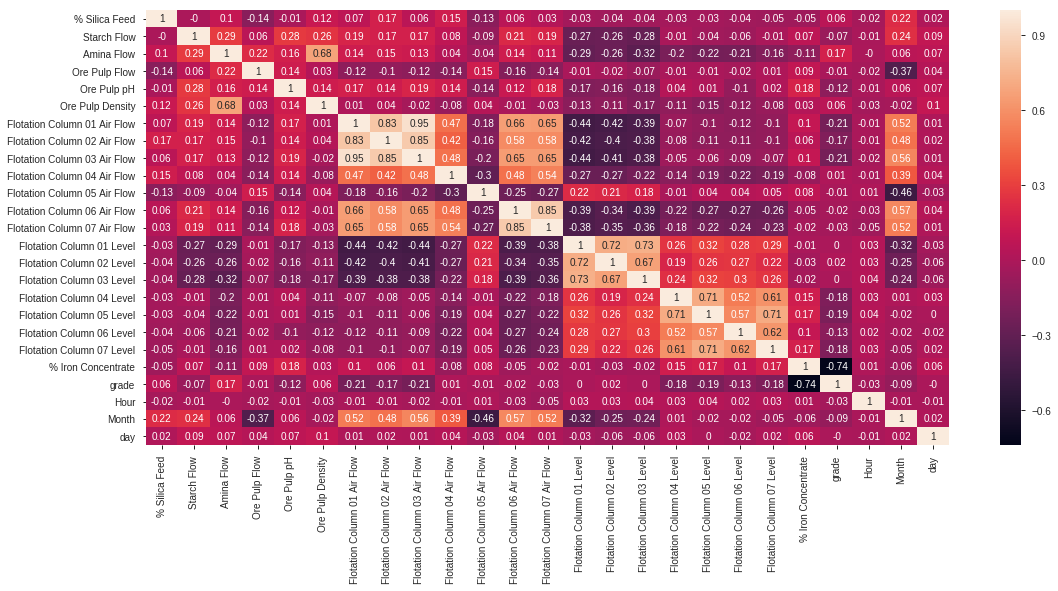

In [ ]:

plt.figure(figsize=[18,8])
sns.heatmap(round(new_df1.iloc[:,1:].corr(),2),annot=True)
plt.show()

**Boxplot:**<br/> Check outliers across the variables

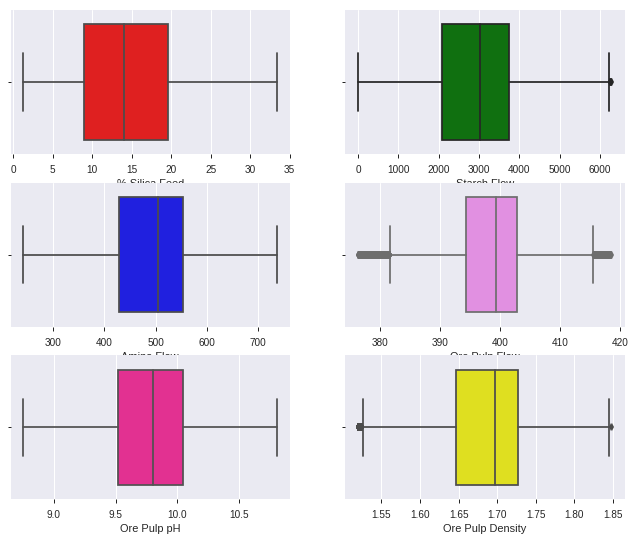

In [ ]:
plt.figure(figsize=[11,9])
plt.subplot(321)
sns.boxplot(new_df1.iloc[:,1],color='r')
plt.subplot(322)
sns.boxplot(new_df1.iloc[:,2],color='g')
plt.subplot(323)
sns.boxplot(new_df1.iloc[:,3],color='b')
plt.subplot(324)
sns.boxplot(new_df1.iloc[:,4],color='violet')
plt.subplot(325)
sns.boxplot(new_df1.iloc[:,5],color='deeppink')
plt.subplot(326)
sns.boxplot(new_df1.iloc[:,6],color='yellow')
plt.show()

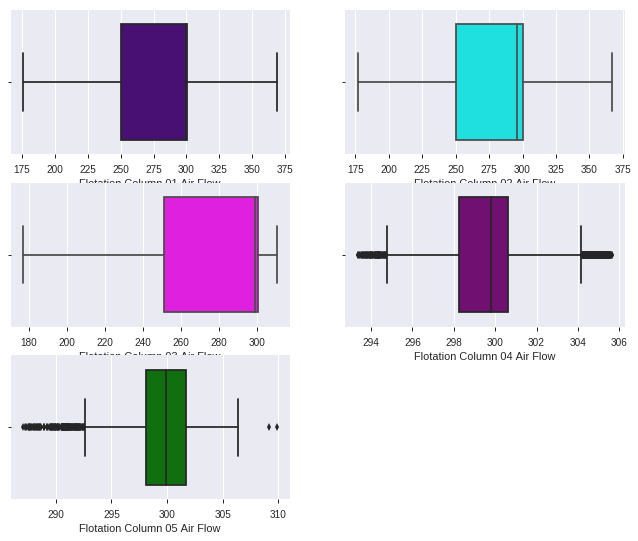

In [ ]:
plt.figure(figsize=[11,9])
plt.subplot(321)
sns.boxplot(new_df1.iloc[:,7],color='indigo')
plt.subplot(322)
sns.boxplot(new_df1.iloc[:,8],color='cyan')
plt.subplot(323)
sns.boxplot(new_df1.iloc[:,9],color='magenta')
plt.subplot(324)
sns.boxplot(new_df1.iloc[:,10],color='purple')
plt.subplot(325)
sns.boxplot(new_df1.iloc[:,11],color='green')
plt.show()

From the quartile division, it is pretty evident that data points across the vairiables are consistent, i.e. no influence of outliers, though standard deviation in most of the variables is large. 

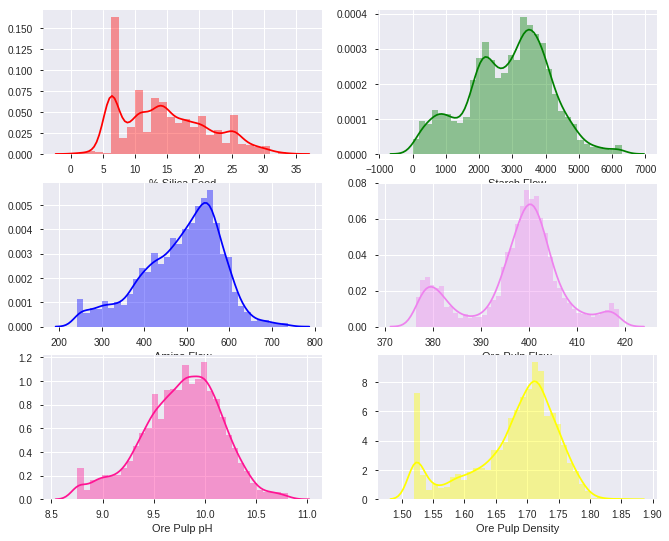

In [ ]:
plt.figure(figsize=[11,9])
plt.subplot(321)
sns.distplot(new_df1.iloc[:,1],color='r')
plt.subplot(322)
sns.distplot(new_df1.iloc[:,2],color='g')
plt.subplot(323)
sns.distplot(new_df1.iloc[:,3],color='b')
plt.subplot(324)
sns.distplot(new_df1.iloc[:,4],color='violet')
plt.subplot(325)
sns.distplot(new_df1.iloc[:,5],color='deeppink')
plt.subplot(326)
sns.distplot(new_df1.iloc[:,6],color='yellow')
plt.show()

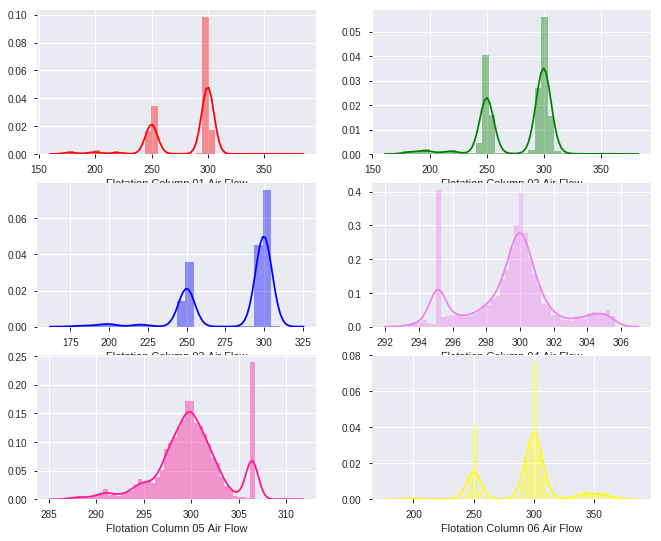

In [ ]:
plt.figure(figsize=[11,9])
plt.subplot(321)
sns.distplot(new_df1.iloc[:,7],color='r')
plt.subplot(322)
sns.distplot(new_df1.iloc[:,8],color='g')
plt.subplot(323)
sns.distplot(new_df1.iloc[:,9],color='b')
plt.subplot(324)
sns.distplot(new_df1.iloc[:,10],color='violet')
plt.subplot(325)
sns.distplot(new_df1.iloc[:,11],color='deeppink')
plt.subplot(326)
sns.distplot(new_df1.iloc[:,12],color='yellow')
plt.show()

In [ ]:
new_df1['grade'].value_counts()                                                 # Frequency of each of 4 categories

2    2437
3    1285
4    1258
1      20
Name: grade, dtype: int64

**Data preparation**

In [ ]:
y=new_df1.loc[:,'grade']
new_df1.drop(['grade'],axis=1,inplace=True)
x=new_df1

**Dummy encode the categorical columns**

In [ ]:
cols=['Hour','Month','day']
cat_cols=x[cols]
cat_cols=cat_cols.astype(str)

In [ ]:
dummies=pd.get_dummies(cat_cols,drop_first=True)

In [ ]:
dummies.head()

Hour_1  Hour_10  Hour_11  Hour_12  ...  day_3  day_4  day_5  day_6
0       0        0        0        0  ...      0      0      0      1
1       0        0        0        0  ...      0      0      0      1
2       0        0        0        0  ...      0      0      0      0
3       0        0        0        0  ...      0      0      0      0
4       0        0        0        0  ...      0      0      0      1

[5 rows x 35 columns]

In [ ]:
input_features=pd.concat([x,dummies],axis=1)                                     # Concat the dummy variables with x(Input features)

In [ ]:
input_features.shape

(5000, 60)

**Train-Test split for training and validation**

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(input_features,y,test_size=0.3,random_state=1234)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3500, 60)
(1500, 60)
(3500,)
(1500,)


##Training models

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=101,C=100)

In [ ]:
lr_model=lr.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
lr_pred=lr_model.predict(x_test)

0.7226666666666667
************
Confusion matrix


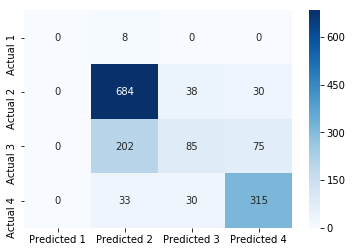

************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.74      0.91      0.81       752
           3       0.56      0.23      0.33       362
           4       0.75      0.83      0.79       378

    accuracy                           0.72      1500
   macro avg       0.51      0.49      0.48      1500
weighted avg       0.69      0.72      0.69      1500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
print(metrics.accuracy_score(y_test,lr_pred))
print('************')
print('Confusion matrix')
lr_cfm=metrics.confusion_matrix(y_test, lr_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(lr_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('************')
print(metrics.classification_report(y_test,lr_pred))

**Decision Tree classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini',max_depth = 10, min_samples_leaf =3, random_state=101)

In [ ]:
dt_model=dt.fit(x_train,y_train)
dt_pred=dt_model.predict(x_test)

0.7633333333333333
************
Confusion matrix


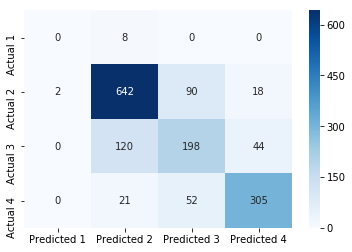

************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.81      0.85      0.83       752
           3       0.58      0.55      0.56       362
           4       0.83      0.81      0.82       378

    accuracy                           0.76      1500
   macro avg       0.56      0.55      0.55      1500
weighted avg       0.76      0.76      0.76      1500



In [ ]:
print(metrics.accuracy_score(y_test,dt_pred))
print('************')
print('Confusion matrix')
dt_cfm=metrics.confusion_matrix(y_test, dt_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(dt_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('************')
print(metrics.classification_report(y_test,dt_pred))

**RandomForest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(oob_score=True)

## GridSearchCV

In [ ]:
random_grid = {'n_estimators': range(5,20,2),
              'max_features' : ['auto', 'sqrt'],
              'max_depth' : [10,20,30,40],
              'min_samples_split':[2,5,10],
              'min_samples_leaf':[1,2,4]}

rf = RandomForestClassifier()

rf_gs = GridSearchCV(rf, random_grid, cv = 3, n_jobs=-1, verbose=2)

rf_gs.fit(x_train, y_train)
y_pred = rf_gs.predict(x_test)


Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  1.6min finished


0.8066666666666666
************
Confusion matrix


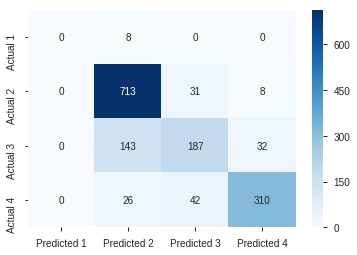

************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.80      0.95      0.87       752
           3       0.72      0.52      0.60       362
           4       0.89      0.82      0.85       378

    accuracy                           0.81      1500
   macro avg       0.60      0.57      0.58      1500
weighted avg       0.80      0.81      0.80      1500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
print(metrics.accuracy_score(y_test,y_pred))
print('************')
print('Confusion matrix')
rf_cfm=metrics.confusion_matrix(y_test, y_pred)

lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(rf_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('************')
print(metrics.classification_report(y_test,y_pred))

**XgBoost**

In [ ]:
from xgboost.sklearn import XGBClassifier

In [ ]:
xgb_gs_clf = XGBClassifier(num_class = 9,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                           seed=42)                         
                        
param_grid = {"max_depth": [10,15,20,30],
              "n_estimators": [300,400,500] , 
              "gamma": [0.03,0.05], 
              "learning_rate": [0.08,0.09],
              "min_child_weight": [5,10], 
              "colsample_bytree": [0.4,0.8], 
              "subsample": [0.50,0.85]} 

grid_search = GridSearchCV(xgb_gs_clf, 
                           param_grid=param_grid,
                           cv = 2,
                           n_jobs=-1,
                           scoring='neg_log_loss',
                           verbose=2)
grid_search.fit(x_train,y_train)

Fitting 2 folds for each of 384 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 46.5min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 57.8min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='mlogloss',
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     num_class=9, objective='multi:softprob...
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.8], 'gamma': [0.03, 0.05],
                         'learning_rate': [0.08, 0.09],
                         'max_depth': [10

In [ ]:
xgboost_y_pred=grid_search.predict(x_test)                                      # Validating the model by predicting the test data

0.8426666666666667
************
Confusion matrix


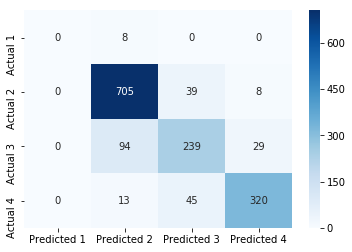

************
 Classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.86      0.94      0.90       752
           3       0.74      0.66      0.70       362
           4       0.90      0.85      0.87       378

    accuracy                           0.84      1500
   macro avg       0.62      0.61      0.62      1500
weighted avg       0.84      0.84      0.84      1500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
print(metrics.accuracy_score(y_test,xgboost_y_pred))
print('************')
print('Confusion matrix')
xgboost_cfm=metrics.confusion_matrix(y_test, xgboost_y_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(xgboost_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('************\n Classification report')
print(metrics.classification_report(y_test,xgboost_y_pred))

**XGBoost**<br/>
Without gridsearch

In [ ]:
xgboost_model=xgb_gs_clf.fit(x_train,y_train)

In [ ]:
xgboost_pred=xgboost_model.predict(x_test)


0.7946666666666666
************
Confusion matrix


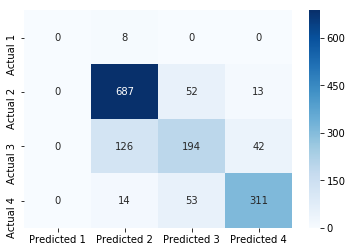

************
 Classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.82      0.91      0.87       752
           3       0.65      0.54      0.59       362
           4       0.85      0.82      0.84       378

    accuracy                           0.79      1500
   macro avg       0.58      0.57      0.57      1500
weighted avg       0.78      0.79      0.79      1500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
print(metrics.accuracy_score(y_test,xgboost_pred))
print('************')
print('Confusion matrix')
xgboost_cm=metrics.confusion_matrix(y_test, xgboost_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(xgboost_cm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('************\n Classification report')
print(metrics.classification_report(y_test,xgboost_pred))

## Model interpretability using Eli5 and SHAP

In [ ]:
eli5.show_weights(xgboost_model,feature_names=x_train.columns.values)

In [ ]:
eli5.explain_prediction(xgboost_model,x_test.iloc[1])

Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',\n              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,\n              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,\n              nthread=None, num_class=9, objective='multi:softprob',\n              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,\n              seed=42, silent=None, subsample=1, verbosity=1)", description='\nFeatures with largest coefficients per class.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[], neg=[FeatureWeight(feature='<BIAS>', weight=-3.819465874256365, std=None, value=1.0), FeatureWeight(feature='% Iron Concentrate', weight=-0.7888903578494183, std=None, value=64.94), FeatureWeight(feature='Flotation Column 06 Level', weight=-0.09789133317501914, std=None, value=406.087), FeatureWeight(feature='% Silica Feed', weight=-0.060242906029788455, std=None, value=13.85), FeatureWeight(feature='Flotation Column 03 Level', weight=-0.060211157629515434, std=None, value=440.978), FeatureWeight(feature='Flotation Column 06 Air Flow', weight=-0.04267983956597515, std=None, value=295.279), FeatureWeight(feature='Starch Flow', weight=-0.03891273507775812, std=None, value=2199.62), FeatureWeight(feature='% Iron Feed', weight=-0.03722577859410471, std=None, value=55.94), FeatureWeight(feature='Hour', weight=-0.033201190437370014, std=None, value=10.0), FeatureWeight(feature='Hour_12', weight=-0.017222302270416594, std=None, value=0.0), FeatureWeight(feature='Month_5', weight=-0.013066272343465149, std=None, value=0.0), FeatureWeight(feature='Flotation Column 04 Air Flow', weight=-0.009137261191493842, std=None, value=299.47), FeatureWeight(feature='Flotation Column 01 Air Flow', weight=-0.0066742298403271935, std=None, value=299.893), FeatureWeight(feature='Flotation Column 07 Air Flow', weight=-0.006495601236208244, std=None, value=302.596), FeatureWeight(feature='Flotation Column 01 Level', weight=-0.002777380371697301, std=None, value=453.596), FeatureWeight(feature='Ore Pulp pH', weight=-0.0014400876310778216, std=None, value=9.51868)], pos_remaining=0, neg_remaining=0), proba=0.0014169945, score=-5.035534307500001, weighted_spans=None), TargetExplanation(target=2, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.8059209565461697, std=None, value=1.0), FeatureWeight(feature='Amina Flow', weight=0.24603418670799454, std=None, value=439.407), FeatureWeight(feature='Flotation Column 01 Air Flow', weight=0.14566060395801067, std=None, value=299.893), FeatureWeight(feature='Flotation Column 02 Air Flow', weight=0.10544798665680963, std=None, value=302.885), FeatureWeight(feature='Ore Pulp pH', weight=0.03957671701981758, std=None, value=9.51868)

In [ ]:
y_test.iloc[1]

3

In [ ]:
eli5.explain_prediction(xgboost_model,x_test.iloc[30])

Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',\n              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,\n              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,\n              nthread=None, num_class=9, objective='multi:softprob',\n              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,\n              seed=42, silent=None, subsample=1, verbosity=1)", description='\nFeatures with largest coefficients per class.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='% Iron Concentrate', weight=0.7436787538699691, std=None, value=66.2), FeatureWeight(feature='Starch Flow', weight=0.41806821991244114, std=None, value=4283.34), FeatureWeight(feature='% Iron Feed', weight=0.2781667974787947, std=None, value=47.05), FeatureWeight(feature='% Silica Feed', weight=0.2781169787299129, std=None, value=28.14), FeatureWeight(feature='Flotation Column 06 Level', weight=0.14046320822022168, std=None, value=336.23), FeatureWeight(feature='Amina Flow', weight=0.04364824292317048, std=None, value=427.017)], neg=[FeatureWeight(feature='<BIAS>', weight=-3.819465874256365, std=None, value=1.0), FeatureWeight(feature='Flotation Column 07 Level', weight=-0.6707052839412185, std=None, value=349.14099999999996), FeatureWeight(feature='Ore Pulp Density', weight=-0.5211178831291619, std=None, value=1.7322), FeatureWeight(feature='Ore Pulp pH', weight=-0.15568609655932522, std=None, value=9.98347), FeatureWeight(feature='Ore Pulp Flow', weight=-0.08966118218654097, std=None, value=392.389), FeatureWeight(feature='day', weight=-0.0755196116134328, std=None, value=2.0), FeatureWeight(feature='Hour_6', weight=-0.06266808338856017, std=None, value=0.0), FeatureWeight(feature='Flotation Column 04 Air Flow', weight=-0.017477953506899756, std=None, value=300.183), FeatureWeight(feature='Hour', weight=-0.01739192228103916, std=None, value=15.0), FeatureWeight(feature='Flotation Column 05 Air Flow', weight=-0.01669600814656307, std=None, value=299.716), FeatureWeight(feature='Month_8', weight=-0.010353204722845802, std=None, value=0.0), FeatureWeight(feature='day_5', weight=-0.009718204018483906, std=None, value=0.0), FeatureWeight(feature='Flotation Column 01 Air Flow', weight=-0.004357773722913558, std=None, value=299.666), FeatureWeight(feature='Flotation Column 03 Level', weight=-0.0020160896111612245, std=None, value=397.222)], pos_remaining=0, neg_remaining=0), proba=0.002337023, score=-3.570692969950001, weighted_spans=None), TargetExplanation(target=2, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='% Iron Concentrate', weight=1.0998352456501714, std=None, value=66.2), FeatureWeight(feature='<BIAS>', weight=0.8059209565461697, 

In [ ]:
y_test.iloc[30]

2

In [ ]:
import shap

In [ ]:
xgboost_explainer_shap=shap.TreeExplainer(xgboost_model)

In [ ]:
print('Actual label\n',y_test[1])
print('******')
shap_values1=xgboost_explainer_shap.shap_values(x_test.iloc[1])
data_to_predict1 = x_test.iloc[1]
shap.initjs()
shap.force_plot(xgboost_explainer_shap.expected_value[2],shap_values1[2],data_to_predict1)

Actual label
 2
******


In [ ]:
print('Actual label\n',y_test[1])
print('******')
shap_values30=xgboost_explainer_shap.shap_values(x_test.iloc[30])
data_to_predict30 = x_test.iloc[30]
shap.initjs()
shap.force_plot(xgboost_explainer_shap.expected_value[1],shap_values30[1],data_to_predict30)

Actual label
 2
******
